## Imports and initialization

In [256]:
import glob
from animal_game.agents import Agent
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool

In [179]:
fs = glob.glob('animal_game/logs/21_06_11/individual/*')
pair_fs = glob.glob('animal_game/logs/21_06_11/pairs/*')

## Get individual metrics

In [180]:
sdf = pd.read_csv('animal_game/logs/21_06_11/individual/wiki_0_305_1_0.01179.txt')
sdf2 = pd.read_csv('animal_game/logs/21_06_11/individual/wiki_0_386_1_0.01179.txt')

In [202]:
_jumps = lambda x: np.nanmean(abs(x - x.shift(1)))

In [203]:
for idx, f in enumerate(fs):
    df = pd.read_csv(f)
    aggdf = df.groupby('iter').agg({'turn':'max', 
                                    'threshold':'first',
                                    'agent': 'first',
                                    'init_seed': 'first',
                                    'prob0': ['mean', _jumps],
                                    'ndens0': 'mean',
                                    'ndens_current0': 'mean',
                                    'response': 'last'}).reset_index()
    aggdf.columns = ['iter', 
                     'performance', 
                     'threshold', 
                     'agent_name', 
                     'init_seed', 
                     'mean_jump',
                     'mean_jump_differential',
                     'mean_ndens',
                     'mean_ndens_current',
                     'last_response']
    aggdf['noise_level'] = aggdf['agent_name'].str.split('_').str[1].astype(float)
    if idx == 0:
        aggs = aggdf.copy()
    else:
        aggs = pd.concat([aggs, aggdf], 
                         ignore_index=True)


<ipython-input-202-627003be9389>:1: RuntimeWarning: Mean of empty slice
  _jumps = lambda x: np.nanmean(abs(x - x.shift(1)))


In [204]:
aggs.to_csv('animal_game/analyses/21_06_11/individual.tsv', sep='\t', index=False)

## Get pair metrics

In [205]:
for idx, f in enumerate(pair_fs): 
    df = pd.read_csv(f)
    df['agent_0'] = df['log_id'].str.split('_').str[:3].str.join('_').iloc[0]
    df['agent_1'] = df['log_id'].str.split('_').str[3:].str.join('_').iloc[0]
    df['agent_speaking'] = np.where(df['agent']==df['agent_0'], 'agent_0', 'agent_1')
    df['jump_speaker'] = np.where(df['agent_speaking']=='agent_0',df['prob0'], df['prob1'])
    df['jump_listener'] = np.where(df['agent_speaking']=='agent_0', df['prob1'], df['prob0'])
    df['jump_difference'] = df['jump_listener'] - df['jump_speaker']
    df['jump_difference_absolute'] = abs(df['jump_listener'] - df['jump_speaker'])
    aggdf = df.groupby('iter').agg({'turn':'max', 
                                    'log_id': 'first',
                                    'agent_0': 'first',
                                    'agent_1': 'first',
                                    'threshold':'first',
                                    'init_seed': 'first',
                                    'prob0': _jumps, #adding
                                    'prob1': _jumps, # adding
                                    'jump_speaker': 'mean',
                                    'jump_listener': 'mean',
                                    'jump_difference': 'mean',
                                    'jump_difference_absolute': 'mean',
                                    'response': 'last',
                                    'ndens0': 'mean',
                                    'ndens1': 'mean',
                                    'ndens_current0': 'mean',
                                    'ndens_current1':'mean'
                                    #
                                   }).reset_index()
    aggdf.columns = ['iter', 'performance', 'pair',
                     'agent_0', 'agent_1',
                     'threshold', 'init_seed', 
                     'mean_jump_differential_0',
                     'mean_jump_differential_1',
                     'mean_jump_speaker', 
                     'mean_jump_listener',
                     'mean_jump_difference',
                     'mean_jump_difference_absolute',
                     'last_response',
                     'ndens0', 'ndens1',
                     'ndens_current0', 'ndens_current1']
    aggdf['noise_level'] = aggdf['agent_0'].str.split('_').str[1].astype(float)
    if idx == 0:
        pair_aggs = aggdf.copy()
    else:
        pair_aggs = pd.concat([pair_aggs, aggdf], 
                              ignore_index=True)

<ipython-input-202-627003be9389>:1: RuntimeWarning: Mean of empty slice
  _jumps = lambda x: np.nanmean(abs(x - x.shift(1)))


In [206]:
pair_aggs.to_csv('animal_game/analyses/21_06_11/pair.tsv', sep='\t', index=False)

## Merge performance

In [278]:
aggs = pd.read_csv('animal_game/analyses/21_06_11/individual.tsv', sep='\t')
pair_aggs = pd.read_csv('animal_game/analyses/21_06_11/pair.tsv', sep='\t')
aggs.drop(['iter', 'threshold'], axis=1, inplace=True)
pair_aggs.drop(['iter', 'threshold'], axis=1, inplace=True)

In [279]:
def _merge_individual(pdf, idf, agent_nr):
    pdf = pdf.merge(idf, 
                    right_on=['agent_name', 'init_seed'],
                    left_on=[f'agent_{agent_nr}', 'init_seed']).drop(['agent_name'], axis=1)
    if agent_nr == '0':
        pdf.drop('noise_level_x', axis=1, inplace=True)
        pdf = pdf.rename({'performance_x': 'performance_pair',
                          'performance_y': f'performance_{agent_nr}',
                          'mean_ndens': f'ndens{agent_nr}_individual',
                          'mean_ndens_current': f'ndens_current{agent_nr}_individual',
                          'noise_level_y': f'noise_level_{agent_nr}',
                          'mean_jump': f'mean_jump_{agent_nr}',
                          'mean_jump_differential': f'mean_jump_differential{agent_nr}_individual',
                          'last_response_x': 'last_response_pair',
                          'last_response_y': f'last_response_{agent_nr}'}, axis=1)
    else:
        pdf.drop('noise_level', axis=1, inplace=True)
        pdf = pdf.rename({'performance': f'performance_{agent_nr}',
                          'mean_ndens': f'ndens{agent_nr}_individual',
                          'mean_ndens_current': f'ndens_current{agent_nr}_individual',
                          'mean_jump': f'mean_jump_{agent_nr}',
                          'mean_jump_differential': f'mean_jump_differential{agent_nr}_individual',
                          'last_response': f'last_response_{agent_nr}',
                          'noise_level': f'noise_level_{agent_nr}'}, axis=1)
    return pdf

In [280]:
pair_aggs = _merge_individual(pair_aggs, aggs, '0')
pair_aggs = _merge_individual(pair_aggs, aggs, '1')

In [281]:
pair_aggs['performance_best'] = np.where(pair_aggs['performance_1'] > pair_aggs['performance_0'], 
                                         pair_aggs['performance_1'],
                                         pair_aggs['performance_0'])
pair_aggs['performance_difference_individuals'] = abs(pair_aggs['performance_1'] - pair_aggs['performance_0'])
pair_aggs['is_gain'] = (pair_aggs['performance_pair'] > pair_aggs['performance_best']).astype(int)
pair_aggs['amount_gain'] = pair_aggs['performance_pair'] - pair_aggs['performance_best']
pair_aggs['performance_ratio'] = pair_aggs['performance_pair'] / pair_aggs['performance_best']

## Get diversity metadata

In [282]:
pair_meta = pd.read_csv('animal_game/models/21_06_11/sampled_pairs.tsv', 
                        sep='\t', index_col=0)[['distance', 'fname_1', 'fname_2']]
pair_meta['pair'] = pair_meta['fname_1'].str.strip('.tsv') + '_' + pair_meta['fname_2'].str.strip('.tsv')
pair_meta = pair_meta[['distance', 'pair']]
pair_meta = pair_meta.rename({'distance': 'diversity'}, axis=1)
pair_aggs = pair_aggs.merge(pair_meta, on='pair')

In [283]:
pair_aggs.to_csv('animal_game/analyses/21_06_11/processed_complete.tsv', sep='\t', index=False)

### Plot path of individual trial

In [416]:
#pair_aggs[np.isclose(pair_aggs['performance_ratio'], 1.5)]
pairs = 'wiki_0_430_wiki_0_450'
agents1 = 'wiki_0_430'
agents2 = 'wiki_0_450'
init_seeds = 'weasel'

In [417]:
trial_df = pd.read_csv([f for f in pair_fs if pairs in f][0])
a1_df = pd.read_csv([f for f in fs if agents1 in f][0]) # this is the right agent
a2_df = pd.read_csv([f for f in fs if agents2 in f][0])
space_df = pd.read_csv('animal_game/models/21_06_11/noised_vectors/wiki_0_430.tsv', 
                       sep='\t', index_col=0)

In [418]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)
scaled_vecs = StandardScaler().fit_transform(space_df)
embedding = reducer.fit_transform(scaled_vecs)

In [419]:
adict = dict(zip(space_df.index, 
                 range(len(space_df.index))))

In [420]:
named_individual = a1_df[a1_df['init_seed']==init_seeds].seed.tolist()
named_idx_individual = [adict[i] for i in named_individual]
xs_individual = [embedding[n,0] for n in named_idx_individual]
ys_individual = [embedding[n,1] for n in named_idx_individual]

In [421]:
named_pair = trial_df[trial_df['init_seed']==init_seeds].seed.tolist()
named_idx_pair = [adict[i] for i in named_pair]
xs_pair = [embedding[n,0] for n in named_idx_pair]
ys_pair = [embedding[n,1] for n in named_idx_pair]

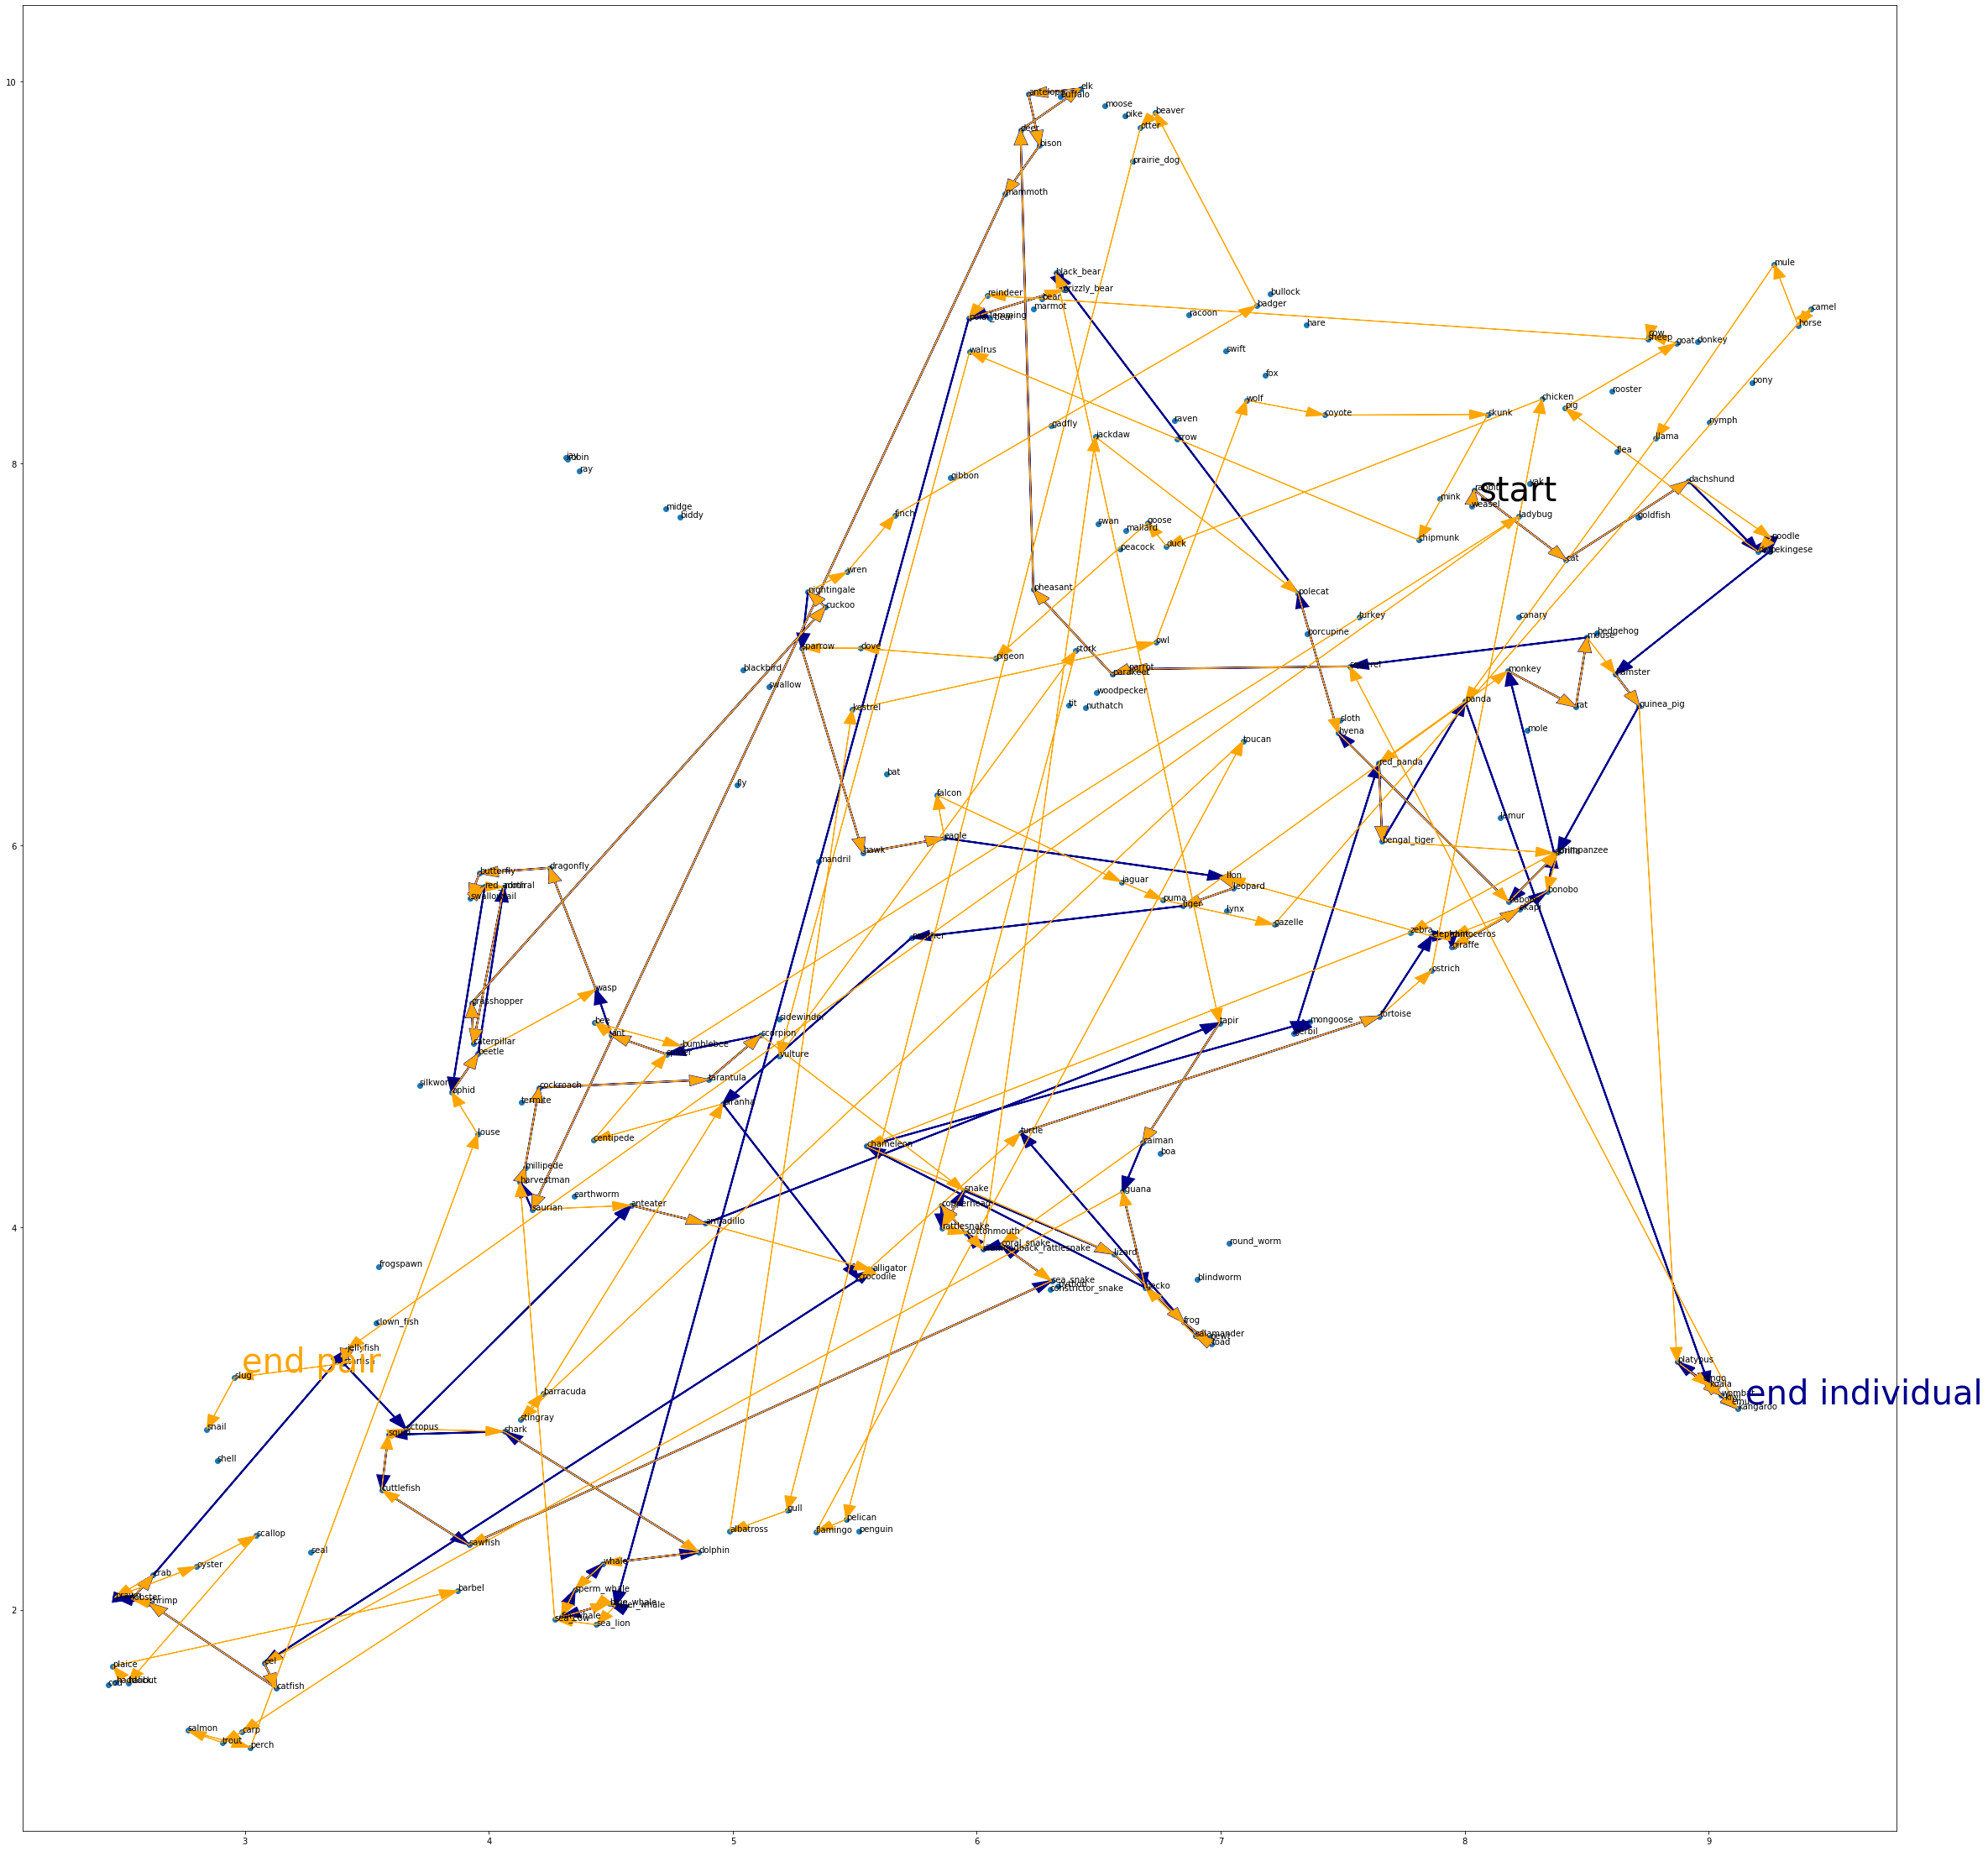

In [422]:
f, ax = plt.subplots(figsize=(40,40))
plt.scatter(embedding[:,0], embedding[:,1])
for idx, e in enumerate(embedding):
    plt.annotate(space_df.index[idx], e)
for idx in range(len(xs_individual)-1):
    plt.arrow(x=xs_individual[idx], 
              y=ys_individual[idx], 
              dx=xs_individual[idx+1]-xs_individual[idx],
              dy=ys_individual[idx+1]-ys_individual[idx],
              shape='full', lw=2,
              length_includes_head=True, head_width=.05, 
              color='darkblue')
    if idx == len(xs_individual)-2:
        plt.annotate('end individual',
                     (xs_individual[idx+1]+.03, ys_individual[idx+1]+.03),
                     fontsize=40, 
                     color='darkblue')
        
for idx in range(len(xs_pair)-1):
    if idx == 0:
        plt.annotate('start',
                     (xs_pair[idx]+.03, ys_pair[idx]+.03),
                     fontsize=40, 
                     color='black')
    plt.arrow(x=xs_pair[idx], 
              y=ys_pair[idx], 
              dx=xs_pair[idx+1]-xs_pair[idx],
              dy=ys_pair[idx+1]-ys_pair[idx],
              shape='full', 
              lw=1,
              length_includes_head=True, 
              head_width=.05, 
              color='orange')
    if idx == len(xs_pair)-2:
        plt.annotate('end pair',
                     (xs_pair[idx]+.03, ys_pair[idx]+.03),
                     fontsize=40, 
                     color='orange')
        
plt.show()

## Performance as a function of...

### Neighborhood density

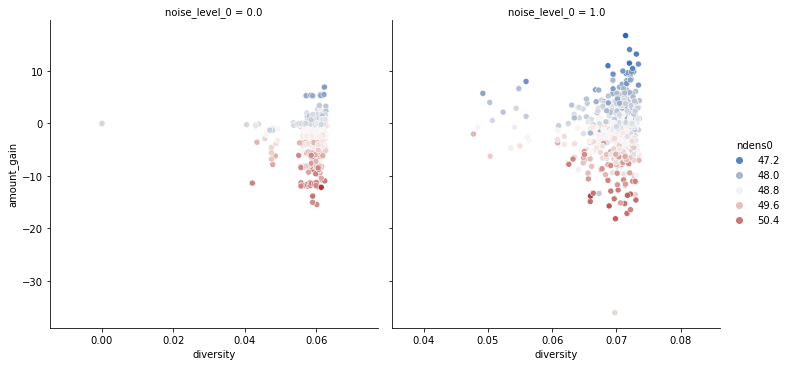

In [429]:
ag = pair_aggs.groupby('pair').agg({'diversity': 'mean', 
                                    'amount_gain': 'mean',
                                    'noise_level_0': 'mean',
                                    'mean_jump_speaker': 'mean',
                                    'ndens0_individual':'mean',
                                    'ndens1_individual':'mean',
                                    'performance_difference_individuals': 'mean',
                                    'ndens_current0': 'mean',
                                    'ndens0': 'mean',
                                    'ndens_current1': 'mean',
                                    'ndens1': 'mean',
                                    'is_gain': 'mean'})
sns.relplot(data=ag,
            x='diversity',
            y='amount_gain', 
            col='noise_level_0',
            hue='ndens0',
            facet_kws={'sharex': False}, 
            palette='vlag')

#### Mean jump length (speaker)

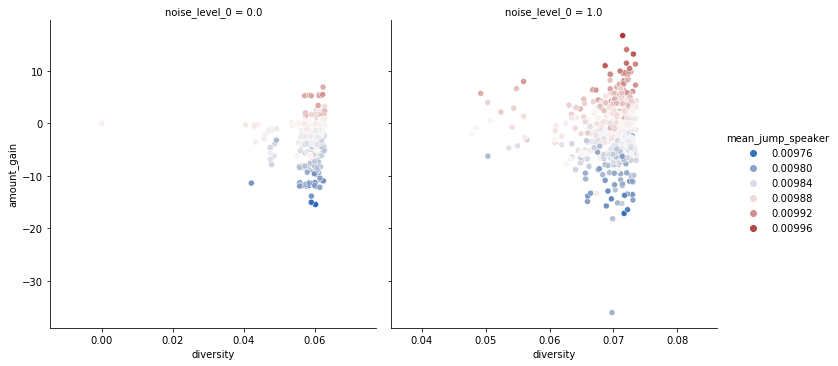

In [427]:
sns.relplot(data=ag,
            x='diversity',
            y='amount_gain', 
            col='noise_level_0',
            hue='mean_jump_speaker',
            facet_kws={'sharex': False}, palette='vlag')

#### Individual performance

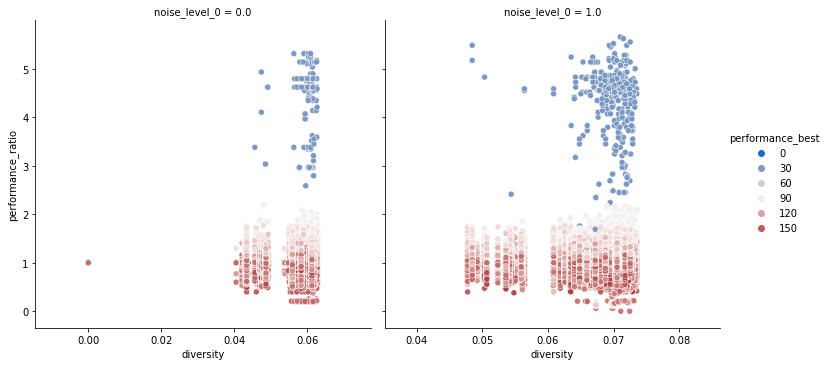

In [428]:
sns.relplot(data=pair_aggs, 
            hue='performance_best', 
            y='performance_ratio', 
            x='diversity',
            col='noise_level_0', 
            facet_kws={'sharex': False}, palette='vlag')

#### Alternation in jumps

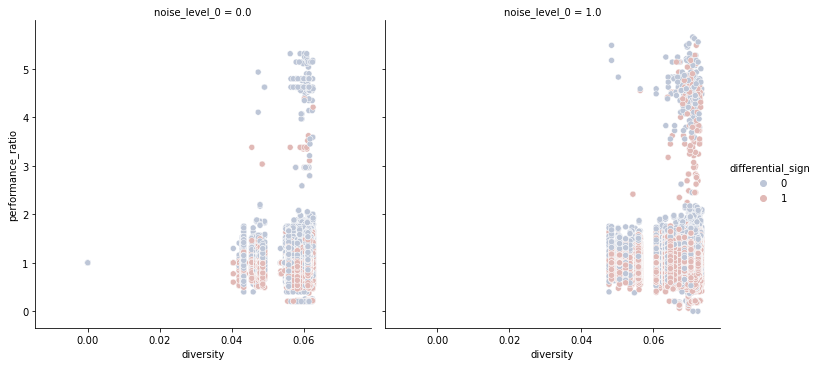

In [430]:
pair_aggs['mean_jump_differential_best'] = np.where(pair_aggs['performance_0'] > pair_aggs['performance_1'], 
                                                    pair_aggs['mean_jump_differential_0'], 
                                                    pair_aggs['mean_jump_differential_1'])
pair_aggs['mean_jump_differential_best_individual'] = np.where(pair_aggs['performance_0'] > pair_aggs['performance_1'], 
                                                    pair_aggs['mean_jump_differential0_individual'], 
                                                    pair_aggs['mean_jump_differential1_individual'])
pair_aggs['differential'] = pair_aggs['mean_jump_differential_best'] - pair_aggs['mean_jump_differential_best_individual']
pair_aggs['differential_sign'] = np.where(pair_aggs['differential']>0, 1, 0)
sns.relplot(data=pair_aggs, 
            hue='differential_sign', 
            y='performance_ratio', 
            x='diversity',
            col='noise_level_0', palette='vlag')
# for certain levels of performance less jumping around for pair makes for better performance
# better tradeoff between long and short jumps?

#### Mean jump length (now listener and difference)

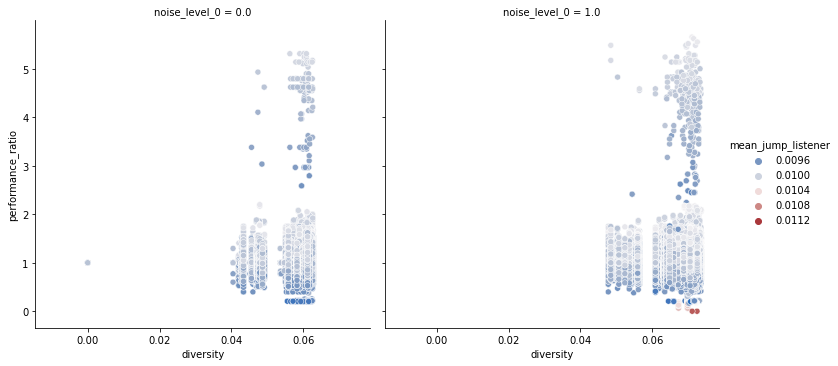

In [431]:
sns.relplot(data=pair_aggs,
            hue='mean_jump_listener', 
            y='performance_ratio', 
            x='diversity',
            col='noise_level_0',
            palette='vlag')

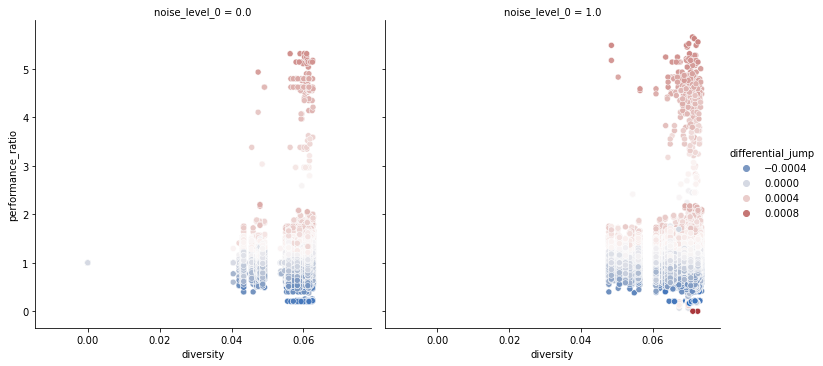

In [434]:
pair_aggs['mean_jump_best'] = np.where(pair_aggs['performance_0'] > pair_aggs['performance_1'],
                                       pair_aggs['mean_jump_0'], pair_aggs['mean_jump_1'])
pair_aggs['differential_jump'] = pair_aggs['mean_jump_speaker'] - pair_aggs['mean_jump_best']
pair_aggs['differential_jump_sign'] = np.where(pair_aggs['differential']>0, 1, 0)
sns.relplot(data=pair_aggs, 
            hue='differential_jump', 
            y='performance_ratio', 
            x='diversity',
            col='noise_level_0', 
            palette='vlag')
# for certain levels of performance less jumping around for pair makes for better performance
# better tradeoff between long and short jumps?

## Individual trials dynamics

In [ ]:
# Look at alternation and how it impacts performance (for both agents) 
    # - also look at whether difference in that from that in individual impacts performance
# Look at difference in mean jumps between best individual and pair (and how it affects performance)
# Look at what cutoff for above is

In [90]:
df['prob_speaker'] = np.where(df['agent'] == 'wiki_0_305', df['prob0'], df['prob1'])
df['prob_listener'] = np.where(df['agent'] == 'wiki_0_305', df['prob1'], df['prob0'])
df['ndens_speaker'] = np.where(df['agent'] == 'wiki_0_305', df['ndens0'], df['ndens1'])
df['ndens_listener'] = np.where(df['agent'] == 'wiki_0_305', df['ndens1'], df['ndens0'])

df['prob_difference'] = df['prob_listener'] - df['prob_speaker']
df['ndens_difference'] = (df['ndens_listener'] - df['ndens_speaker']) / 100

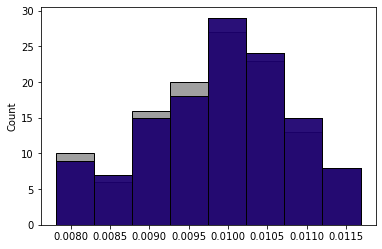

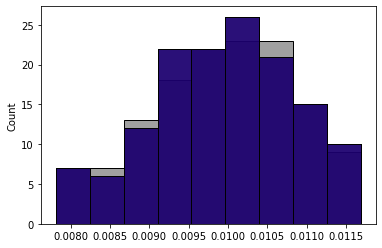

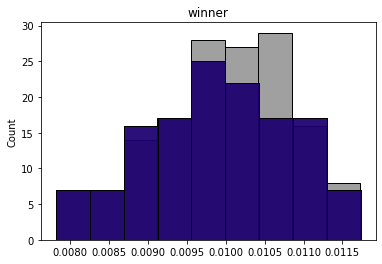

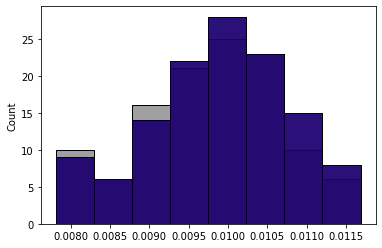

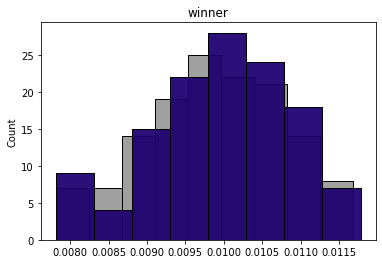

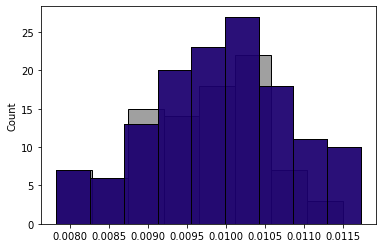

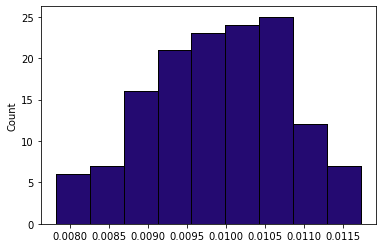

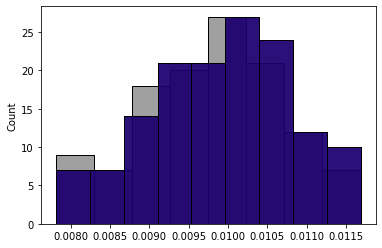

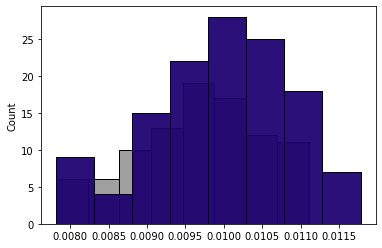

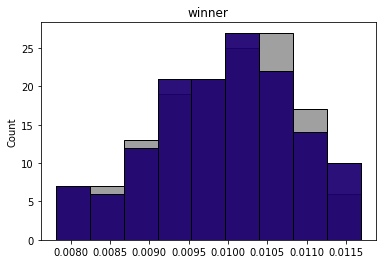

In [107]:
for i in range(10):
    sns.histplot(x=df[df['iter']==i].prob_speaker.tolist(), color='grey')
    sns.histplot(x=sdf[sdf['iter']==i].prob0.tolist(), color='darkred')
    sns.histplot(x=sdf2[sdf2['iter']==i].prob0.tolist(), color='darkblue')
    plt.show()

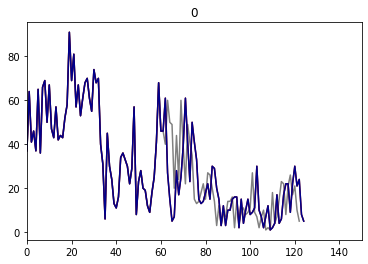

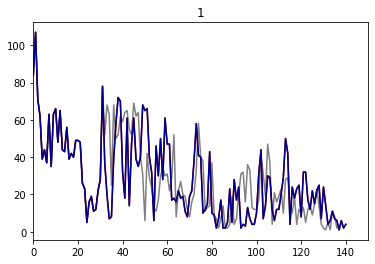

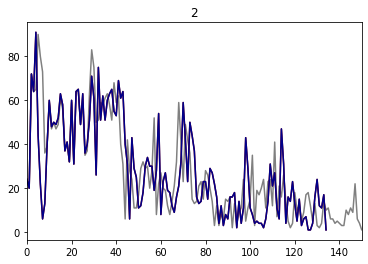

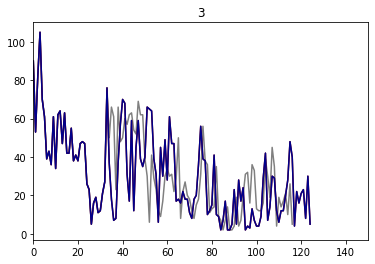

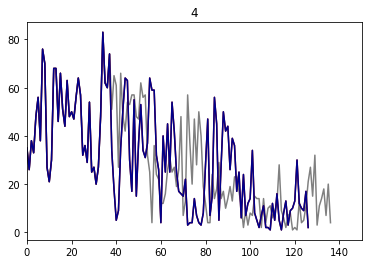

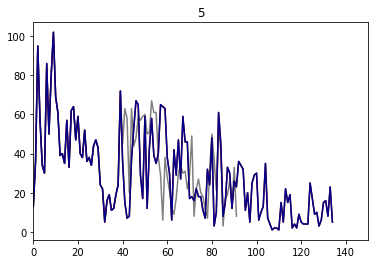

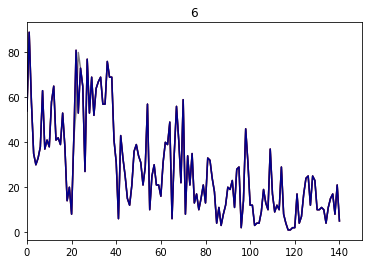

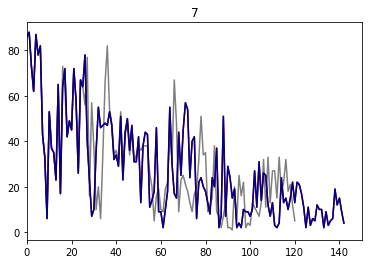

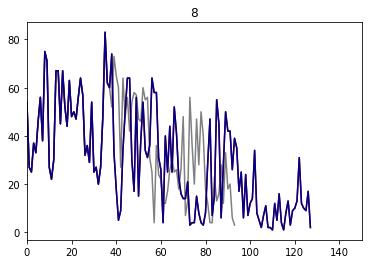

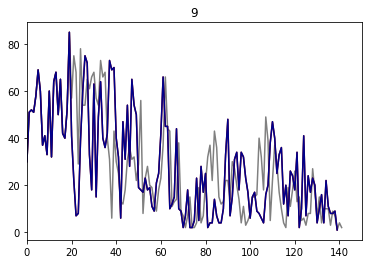

In [101]:
for i in range(10):
    sns.lineplot(x=range(len(df[df['iter']==i].ndens_current0.tolist())), 
                 y=df[df['iter']==i].ndens_current0.tolist(), color='grey')
    sns.lineplot(x=range(len(sdf[sdf['iter']==i].ndens_current0.tolist())), 
                 y=sdf[sdf['iter']==i].ndens_current0.tolist(), color='darkred')
    sns.lineplot(x=range(len(sdf2[sdf2['iter']==i].ndens_current0.tolist())), 
                 y=sdf2[sdf2['iter']==i].ndens_current0.tolist(), color='darkblue')
    plt.xlim(0,150)
    plt.title(i)
    plt.show()

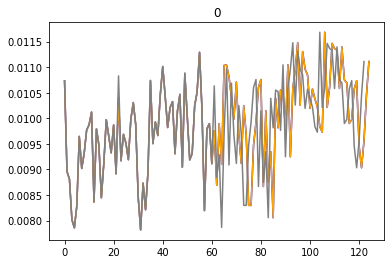

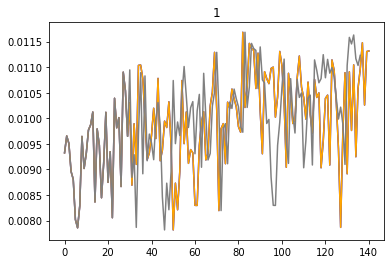

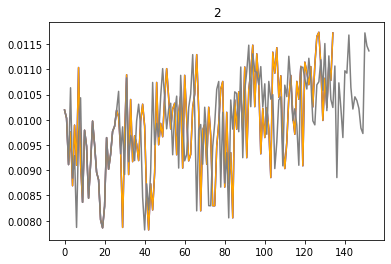

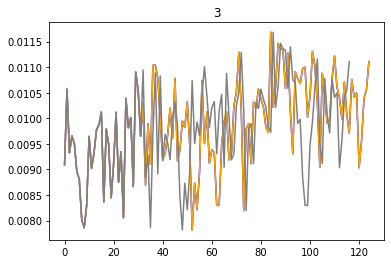

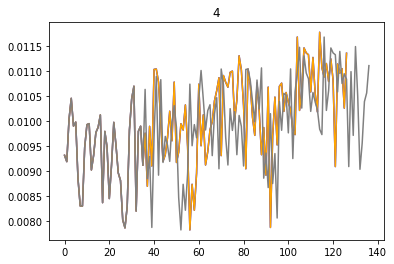

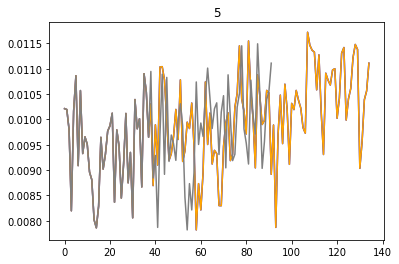

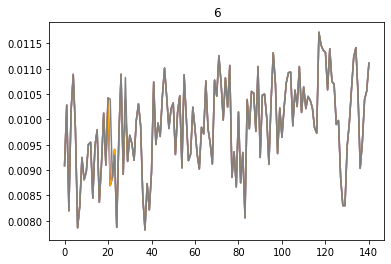

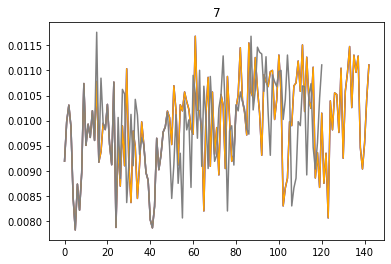

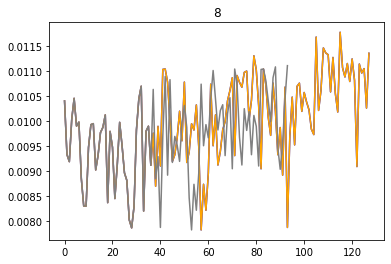

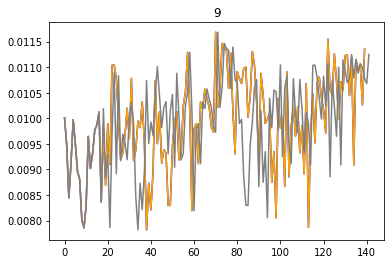

In [72]:
for i in range(10):
    sns.lineplot(x=range(len(sdf[sdf['iter']==i].prob0.tolist())), 
                 y=sdf[sdf['iter']==i].prob0.tolist(), color='darkblue')
    sns.lineplot(x=range(len(sdf2[sdf2['iter']==i].prob0.tolist())), 
                 y=sdf2[sdf2['iter']==i].prob0.tolist(), color='orange')
    sns.lineplot(x=range(len(df[df['iter']==i].prob_listener.tolist())), 
                 y=df[df['iter']==i].prob_listener.tolist(), color='grey')
    plt.title(i)
    plt.show()
#sns.lineplot(x=df[df['iter']==0].prob0.tolist())

## Jumps ~ interaction

Diversity of a pair impacts the search pattern of the pair:
- LMER (1): Effect of diversity on mean jump for the listener
- Diversity prevents the pair from getting stuck in local minima
- -> can we see that reflected in performance? <br>

Performance analysis: does more diversity lead to performance gains from individuals?
- GLMER (1): Effect of diversity on binary predictor for gain
- Confirm that this may have to do with jumps by looking at LMER (2) gain ~ mean jump

Control analyses:
- Is this modulated by individual performance and diversity in performance within a pair?
    - Add individual performance to GLMER (1) and compare models
        - Yes, it does. For high individual performance there is not much to be gained.
    - Add diversity in performance on top of that and compare models. 
        - To do.
